In [28]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (13.5, 13.5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Loading Frey Faces 

In [1]:
data_path = '/home/andrei/ml/datasets/'

In [47]:
ff = scipy.io.loadmat(data_path + 'frey_rawface.mat', squeeze_me=True, struct_as_record=False)

In [48]:
# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = ff["ff"].T
# .T.reshape((-1, img_rows, img_cols))

In [49]:
ff.shape

(1965, 560)

### Visualizing Frey Faces 

In [25]:
# from http://dohmatob.github.io/research/2016/10/22/VAE.html
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
    return figure

array([[  81.,  136.,  167., ...,  208.,   84.,  103.],
       [ 105.,  139.,  165., ...,  224.,  144.,   74.],
       [  56.,  126.,  161., ...,  225.,  180.,   98.],
       ..., 
       [ 204.,  160.,  126., ...,  149.,  141.,  140.],
       [ 152.,  154.,  129., ...,  159.,  137.,  141.],
       [  93.,  144.,  138., ...,  171.,  171.,  180.]])

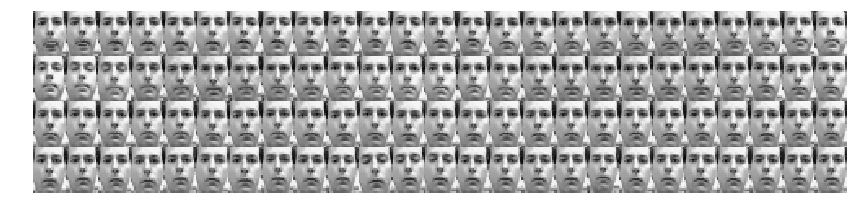

In [26]:
show_examples(ff, n=100, n_cols=25)

### Prepping the Data 

In [29]:
np.ceil(2/3)

1.0

In [37]:
class data_reader(object):
    
    def __init__(self,X,batch_size=1):
        self.X = X
        self.batch_number = 0 
        self.batch_size = batch_size
        self.num_batches = int(np.ceil(X.shape[0] / batch_size))
    
    def get_next_batch(self):
        low_ix = self.batch_number*self.batch_size 
        up_ix = (self.batch_number + 1)*self.batch_size
        if up_ix >= self.X.shape[0]:
            up_ix = self.X.shape[0]
            self.batch_number = 0 # reset batch_number to zero
        else:
            self.batch_number = self.batch_number + 1
        return self.X[low_ix:up_ix,:]

In [50]:
batch_size = 100
ff_reader = data_reader(ff, batch_size)

In [51]:
ff_reader.num_batches

20

In [53]:
ff_reader.get_next_batch().shape

(100, 560)

### Training a VAE 

In [54]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected, batch_norm

In [62]:
# Construction phase
n_inputs = 28*20
n_hidden1 = 200
n_hidden2 = 200
n_hidden3 = 20 # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

with tf.contrib.framework.arg_scope(
        [fully_connected],
        activation_fn = tf.nn.elu,
        weights_initializer = tf.contrib.layers.variance_scaling_initializer()):
    X = tf.placeholder(tf.float32, shape = [None, n_inputs])
    hidden1 = fully_connected(X, n_hidden1)
    hidden2 = fully_connected(hidden1, n_hidden2, activation_fn=tf.nn.tanh)
    hidden2_mean = fully_connected(hidden1, n_hidden2)
    hidden3_mean = fully_connected(hidden2, n_hidden3, activation_fn=None)
    hidden3_gamma = fully_connected(hidden2, n_hidden3, activation_fn=None)
    hidden3_sigma = tf.exp(0.5 * hidden3_gamma)
    noise1 = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
    hidden3 = hidden3_mean + hidden3_sigma * noise
    hidden4 = fully_connected(hidden3, n_hidden4)
    hidden5 = fully_connected(hidden4, n_hidden5, activation_fn=tf.nn.tanh)
    hidden6_mean = fully_connected(hidden5, n_outputs, activation_fn=tf.nn.sigmoid)
    hidden6_gamma = fully_connected(hidden5, n_outputs, activation_fn=None)
    hidden6_sigma = tf.exp(0.5 * hidden6_gamma)
    noise2 = tf.random_normal(tf.shape(hidden6_sigma), dtype=tf.float32)
    outputs = hidden6_mean + hidden6_sigma * noise2

In [ ]:
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

reconstructio_loss = 
cost = reconstruction_loss + latent_loss